In [91]:
import os, dendropy, sys, tqdm, pickle
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
plt.style.use('paper_style.mplstyle')
from statsmodels.stats.multitest import multipletests
import mtbvartools as vt
import phyoverlap2 as po
from mtbvartools.vcf import filterDataFrame
from mtbvartools.dasktools import startClient, subproc

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

# Measure Variant Modernity

## Pre-calculate statistic at all nodes

In [3]:
tree_path = 'datasets/variants/global/241104_ancestor_calls.vcb/tree.nwk'
prune_labels = ['canettii', 'SRR10522783']
statistic_path = 'tmp/root_dist.global.pkl'

dist_dict = po.getDistToRoot(
    tree_path, prune_labels)

pickle.dump(dist_dict, open(statistic_path, 'wb'))

100%|███████████████████████████████████████████████████████████████████████| 110430/110430 [00:00<00:00, 412038.12it/s]


## Run analysis

In [10]:
# storage of all outputs
combined_outputs = []

**WhiB6 and SlfR**

In [11]:
annotation_df = pd.read_csv(
    'datasets/variants/global/241104_event_calls.vcb/event_calls.annotated.csv',
    index_col=['pos', 'ref', 'alt'])

deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05,}  # predicted deleterious via SIFT

deleterious_annotation_df = filterDataFrame(
    annotation_df, function_dict=deleterious_settings)

miss_settings = {
    'miss_count': lambda x: float(x) < 55260 * .05,}
pass_filters_df = filterDataFrame(
    deleterious_annotation_df, function_dict=miss_settings)

pass_filters_df.to_csv('tmp/deleterious_annotations.tmp.csv')

In [12]:
tree_path = 'datasets/variants/global/241104_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal4119',
    'L2': 'internal26428',
    'L4': 'internal55169'}

genes_list = ['Rv0042c', 'Rv3862c']

statistic_list = {
    'root dist': 'tmp/root_dist.global.pkl',}
    
annotations_path = 'tmp/deleterious_annotations.tmp.csv'
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
n_permutations = 100000

@subproc
def geneStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (geneid, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for geneid, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(geneid, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_nodes = po.getGeneAltEventNodes(
                geneid, event_vcb, annotation_df, None, node_set)
            ind_nodes_dict[(geneid, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (geneid, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [13]:
# define jobs and split work
all_jobs = list(product(genes_list, lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 10
n_jobs = 10

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        geneStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-03-27 14:38:02 - Launching LocalCluster client (10 workers)


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.17s/it]


In [14]:
combined_outputs.append(outputs_df)

**espACD**

In [15]:
annotated_calls_path = 'datasets/variants/global/241104_event_calls.vcb/event_calls.genomic.csv'

anno_calls = pd.read_csv(
    annotated_calls_path, index_col=['pos', 'ref', 'alt'])
# get position vector
pos_vector = anno_calls.index.get_level_values('pos')

# generate index lists of variants for the sites of interest
target_indexes = {
    'SNP_siteA': anno_calls.index[np.all([
        pos_vector <= 4057190 + 5,
        pos_vector >= 4057190 - 5], axis=0)],
    'SNP_siteB': anno_calls.index[np.all([
        pos_vector <= 4057367 + 5,
        pos_vector >= 4057367 - 5], axis=0)],
    'DEL_A': anno_calls.index[
        pos_vector == 4056663],
    'DEL_B': anno_calls.index[
        pos_vector == 4056945]}

flat_indexes = np.concatenate(
    [idx for idx in target_indexes.values()])
anno_calls.loc[
    flat_indexes].to_csv('tmp/espACD_upstream_variants.tmp.csv')

In [16]:
tree_path = 'datasets/variants/global/241104_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal4119',
    'L2': 'internal26428',
    'L4': 'internal55169'}

ind_variants_list = {
    'espA up': 'tmp/espACD_upstream_variants.tmp.csv'}

statistic_list = {
    'root dist': 'tmp/root_dist.global.pkl',}
    
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
n_permutations = 100000

@subproc
def targetStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (path, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for target_var, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(target_var, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_variants_df = pd.read_csv(
                ind_variants_list[target_var], index_col=['pos', 'ref', 'alt'])
            ind_nodes = po.getVariantAltEventNodes(
                ind_variants_df, event_vcb, node_set)
            ind_nodes_dict[(target_var, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (target_var, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [17]:
# define jobs and split work
all_jobs = list(product(ind_variants_list.keys(), lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 5
n_jobs = 5

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        targetStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-03-27 14:40:15 - Launching LocalCluster client (5 workers)


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it]


In [18]:
combined_outputs.append(outputs_df)

In [19]:
combined_df = pd.concat(
    combined_outputs)
combined_df.index.names = ('site', 'metric', 'lineage')
combined_df.sort_index()
combined_df.index = combined_df.index.droplevel('metric')
combined_df.to_csv('outputs/tables/TableS7_modernity.csv')

# Variant Association with Antibiotic Resistance

## Run Analysis

In [59]:
outputs_list = []

**WhiB6 + Rv0042c**

In [60]:
annotation_df = pd.read_csv(
    'datasets/variants/global/241104_event_calls.vcb/event_calls.annotated.csv',
    index_col=['pos', 'ref', 'alt'])

deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05,}  # predicted deleterious via SIFT

deleterious_annotation_df = filterDataFrame(
    annotation_df, function_dict=deleterious_settings)

miss_settings = {
    'miss_count': lambda x: float(x) < 55260 * .05,}
pass_filters_df = filterDataFrame(
    deleterious_annotation_df, function_dict=miss_settings)

pass_filters_df.to_csv('tmp/deleterious_annotations.tmp.csv')

In [61]:
# definitions

tree_path = 'datasets/variants/global/241104_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal4119',
    'L2': 'internal26428',
    'L4': 'internal55169'}
drugs_list = [
    'isoniazid', 'rifampicin', 'streptomycin', 'ethambutol', 'pyrazinamide']
genes_list = [
    'Rv0042c', 'Rv3862c']

target_settings = None

abx_variants_path = 'datasets/known_abx_variants.csv'
annotations_path = 'tmp/deleterious_annotations.tmp.csv'
variant_vcb_path = 'datasets/variants/global/241104_variant_calls.vcb'
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
n_permutations = 100000

# @subproc
def geneAbxAssoc(
        joblist_gene_drug_lineage,
        tree_path,
        prune_labels,
        lineage_seeds,
        drugs_list,
        genes_list,
        target_settings,
        abx_variants_path,
        annotations_path,
        variant_vcb_path,
        event_vcb_path,
        n_permutations,):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)
    # get leaf lookup dictionary
    tree_dict = po.getChildNodeDict(
        tree=loaded_tree, only_leaves=True)
    
    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}
    
    # load in variant & event vcbs
    variant_vcb = vt.CallBytestream(variant_vcb_path, True, False)
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)

    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])
    
    # precalculate leaf (dependent) calls for each drug
    dep_leaves_dict = {}
    for drug, lineage in product(drugs_list, lineage_seeds.keys()):
        abx_variant_df = pd.read_csv(  # load in variants
            abx_variants_path,
            index_col=['pos', 'ref', 'alt'])
        dep_target_calls = abx_variant_df.loc[
            abx_variant_df.drug == drug]
        leaf_set = set(
            node_df_dict[lineage].loc[node_df_dict[lineage].is_leaf, 'head_node'])
        dep_leaves = po.getVariantLeaves(
            dep_target_calls, variant_vcb, leaf_set)
        dep_leaves_dict[(drug, lineage)] = dep_leaves

    ## iterate on assigned products of gene x drug x lineage
    ind_nodes_dict = {}  # register (geneid, lineage) pairs that have already run on the worker on the fly
    overlap_output_list = []  # output list
    for geneid, drug, lineage in joblist_gene_drug_lineage:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(geneid, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(node_df_dict[lineage].head_node)
            ind_nodes = po.getGeneAltEventNodes(
                geneid, event_vcb, annotation_df, target_settings, node_set)
            ind_nodes_dict[geneid] = ind_nodes
        if len(ind_nodes) == 0:
            continue  # skip if no high quality nodes for this gene
        # run permutation test
        overlap_output = po.testMeanOverlap(
            ind_nodes, dep_leaves_dict[(drug, lineage)], tree_dict, node_df_dict[lineage],
            n_permutations=n_permutations)
        overlap_output.name = (geneid, drug, lineage)
        overlap_output_list.append(overlap_output)
    return pd.DataFrame(overlap_output_list)

In [62]:
# define jobs and split work
all_jobs = list(product(genes_list, drugs_list, lineage_seeds.keys()))
np.random.shuffle(all_jobs)
n_workers = 15
n_jobs = 15

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        geneAbxAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        drugs_list,
        genes_list,
        target_settings,
        abx_variants_path,
        annotations_path,
        variant_vcb_path,
        event_vcb_path,
        n_permutations))

for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()

client.shutdown()

2025-04-14 10:55:54 - Launching LocalCluster client (15 workers)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:35<00:00, 10.37s/it]


**EspACD**

Cumulative variant sites to consider:  
- 4057189 - SNPs (close A)
- 4057366 - SNPs (far B)
- 4056663 - deletion position (A)
- 4056945 - deletion position (B)

In [63]:
annotated_calls_path = 'datasets/variants/global/241104_event_calls.vcb/event_calls.genomic.csv'

anno_calls = pd.read_csv(
    annotated_calls_path, index_col=['pos', 'ref', 'alt'])
# get position vector
pos_vector = anno_calls.index.get_level_values('pos')

# generate index lists of variants for the sites of interest
target_indexes = {
    'SNP_siteA': anno_calls.index[np.all([
        pos_vector <= 4057190 + 5,
        pos_vector >= 4057190 - 5], axis=0)],
    'SNP_siteB': anno_calls.index[np.all([
        pos_vector <= 4057367 + 5,
        pos_vector >= 4057367 - 5], axis=0)],
    'DEL_A': anno_calls.index[
        pos_vector == 4056663],
    'DEL_B': anno_calls.index[
        pos_vector == 4056945]}

flat_indexes = np.concatenate(
    [idx for idx in target_indexes.values()])
anno_calls.loc[
    flat_indexes].to_csv('tmp/espACD_upstream_variants.tmp.csv')

In [64]:
# definitions

tree_path = 'datasets/variants/global/241104_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal4119',
    'L2': 'internal26428',
    'L4': 'internal55169'}
drugs_list = [
    'isoniazid', 'rifampicin', 'streptomycin', 'ethambutol', 'pyrazinamide']

target_settings = None

abx_variants_path = 'datasets/known_abx_variants.csv'
ind_variants_path = 'tmp/espACD_upstream_variants.tmp.csv'
variant_vcb_path = 'datasets/variants/global/241104_variant_calls.vcb'
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
n_permutations = 100000

# @subproc
def targetVariantAbxAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        drugs_list,
        genes_list,
        target_settings,
        abx_variants_path,
        ind_variants_path,
        variant_vcb_path,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)
    # get leaf lookup dictionary
    tree_dict = po.getChildNodeDict(
        tree=loaded_tree, only_leaves=True)
    
    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}
    
    # load in variant & event vcbs
    variant_vcb = vt.CallBytestream(variant_vcb_path, True, False)
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)

    # load in variants
    ind_variants_df = pd.read_csv(
        ind_variants_path,
        index_col=['pos', 'ref', 'alt'])
    
    # precalculate leaf (dependent) calls for each drug
    dep_leaves_dict = {}
    for drug, lineage in product(drugs_list, lineage_seeds.keys()):
        abx_variant_df = pd.read_csv(  # load in variants
            abx_variants_path,
            index_col=['pos', 'ref', 'alt'])
        dep_target_calls = abx_variant_df.loc[
            abx_variant_df.drug == drug]
        leaf_set = set(
            node_df_dict[lineage].loc[node_df_dict[lineage].is_leaf, 'head_node'])
        dep_leaves = po.getVariantLeaves(
            dep_target_calls, variant_vcb, leaf_set)
        dep_leaves_dict[(drug, lineage)] = dep_leaves

    ## iterate on assigned products of drug x lineage
    overlap_output_list = []  # output list
    for drug, lineage in joblist:
        # identify variant nodes
        node_set = set(node_df_dict[lineage].head_node)
        ind_nodes = po.getVariantAltEventNodes(
            ind_variants_df, event_vcb, node_set)
        if len(ind_nodes) == 0:
            continue  # skip if no high quality nodes for this situation
        # run permutation test
        overlap_output = po.testMeanOverlap(
            ind_nodes, dep_leaves_dict[(drug, lineage)], tree_dict, node_df_dict[lineage],
            n_permutations=n_permutations)
        overlap_output.name = ('espACD', drug, lineage)
        overlap_output_list.append(overlap_output)
    return pd.DataFrame(overlap_output_list)

In [65]:
# define jobs and split work
all_jobs = list(product(drugs_list, lineage_seeds.keys()))
np.random.shuffle(all_jobs)
n_workers = 15
n_jobs = 15

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        targetVariantAbxAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        drugs_list,
        genes_list,
        target_settings,
        abx_variants_path,
        ind_variants_path,
        variant_vcb_path,
        event_vcb_path,
        n_permutations))

for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()

client.shutdown()

2025-04-14 10:58:33 - Launching LocalCluster client (15 workers)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:42<00:00,  2.83s/it]


In [66]:
outputs_df = pd.concat(outputs_list)
outputs_df.index.names = ('site', 'antibiotic', 'lineage')
outputs_df = outputs_df.loc[
    pd.IndexSlice[
        ['Rv3862c', 'espACD', 'Rv0042c'],
        ['isoniazid', 'rifampicin', 'streptomycin', 'ethambutol', 'pyrazinamide'],
        ['L1', 'L2', 'L4']]]
outputs_df.loc[:, 'bh_est_pvalue'] = multipletests(
    outputs_df.est_pvalue, method='fdr_bh', alpha=0.05)[1]
outputs_df.loc[:, 'fdr_significant'] = multipletests(
    outputs_df.est_pvalue, method='fdr_bh', alpha=0.05)[0]
outputs_df.to_csv('outputs/tables/TableS7_abx_associations.csv')

# Measure Variant Transmission

## Pre-calculate statistics

**Prepare Mask**
Need to identify sites that:
- (1) do not pass Max Marin's threshold or
- (2) do not pass my miss threshold (here, 25%)

In [6]:
miss_threshold = 0.25
n_strains = len(vt.loadTree(
    'datasets/variants/global/241104_event_calls.vcb/tree.nwk').leaf_nodes())

miss_counts = np.load('datasets/global_miss_counts.npz')['miss_counts']
miss_mask = miss_counts >= miss_threshold * n_strains

bed_mask = vt.bedToMask(
    'datasets/rlc_plus_lowmap_marin.bed',
    len(miss_counts))

fail_mask = np.any([
    miss_mask, bed_mask],
    axis=0)

---
**Store TBL phenotypes**  
Precalculate a dictionary storing the mean TBL from every node of the tree.

In [7]:
statistic_path = 'tmp/mean_terminal_branch_lengths.global.pkl'
ancestor_vcb_path = 'datasets/variants/global/241104_ancestor_calls.vcb'
tree_path = 'datasets/variants/global/241104_ancestor_calls.vcb/tree.nwk'
prune_labels = ['canettii', 'SRR10522783']

if os.path.exists(statistic_path):
    print(f'{statistic_path} found!')
else:
    mean_tbl, _ = po.getMeanTerminalBranchLengths(
        ancestor_vcb_path,
        tree_path,
        fail_mask,
        prune_labels)
    os.makedirs(os.path.dirname(statistic_path), exist_ok=True)
    pickle.dump(mean_tbl, open(statistic_path, 'wb'))

precalculating leaf tbls....


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 55259/55259 [02:32<00:00, 362.32it/s]


calculating all mean tbls...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 110430/110430 [00:01<00:00, 76039.58it/s]


In [8]:
statistic_path = 'tmp/mean_terminal_branch_lengths.abxsen.pkl'
ancestor_vcb_path = 'datasets/variants/global/250209_abxsen_ancestor_calls.vcb'
tree_path = 'datasets/variants/global/250209_abxsen_ancestor_calls.vcb/tree.nwk'
prune_labels = ['canettii', 'SRR10522783']

if os.path.exists(statistic_path):
    print(f'{statistic_path} found!')
else:
    mean_tbl, _ = po.getMeanTerminalBranchLengths(
        ancestor_vcb_path,
        tree_path,
        fail_mask,
        prune_labels)
    os.makedirs(os.path.dirname(statistic_path), exist_ok=True)
    pickle.dump(mean_tbl, open(statistic_path, 'wb'))

precalculating leaf tbls....


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30890/30890 [01:05<00:00, 474.61it/s]


calculating all mean tbls...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 61734/61734 [00:00<00:00, 90364.06it/s]


In [9]:
statistic_path = 'tmp/mean_terminal_branch_lengths.abxres.pkl'
ancestor_vcb_path = 'datasets/variants/global/250216_abxres_ancestor_calls.vcb'
tree_path = 'datasets/variants/global/250216_abxres_ancestor_calls.vcb/tree.nwk'
prune_labels = ['canettii', 'SRR10522783']

if os.path.exists(statistic_path):
    print(f'{statistic_path} found!')
else:
    mean_tbl, _ = po.getMeanTerminalBranchLengths(
        ancestor_vcb_path,
        tree_path,
        fail_mask,
        prune_labels)
    os.makedirs(os.path.dirname(statistic_path), exist_ok=True)
    pickle.dump(mean_tbl, open(statistic_path, 'wb'))

precalculating leaf tbls....


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 24369/24369 [00:30<00:00, 812.28it/s]


calculating all mean tbls...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 48696/48696 [00:00<00:00, 77671.53it/s]


## Run analysis

### Full Isolate Tree

In [10]:
# storage of all outputs
combined_outputs = []

**WhiB6 and SlfR**

In [11]:
annotation_df = pd.read_csv(
    'datasets/variants/global/241104_event_calls.vcb/event_calls.annotated.csv',
    index_col=['pos', 'ref', 'alt'])

deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05,}  # predicted deleterious via SIFT

deleterious_annotation_df = filterDataFrame(
    annotation_df, function_dict=deleterious_settings)

miss_settings = {
    'miss_count': lambda x: float(x) < 55260 * .05,}
pass_filters_df = filterDataFrame(
    deleterious_annotation_df, function_dict=miss_settings)

pass_filters_df.to_csv('tmp/deleterious_annotations.tmp.csv')

In [13]:
tree_path = 'datasets/variants/global/241104_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal4119',
    'L2': 'internal26428',
    'L4': 'internal55169'}

genes_list = ['Rv0042c', 'Rv3862c']

statistic_list = {
    'TBL': 'tmp/mean_terminal_branch_lengths.global.pkl',}
    
annotations_path = 'tmp/deleterious_annotations.tmp.csv'
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
n_permutations = 100000

@subproc
def geneStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (geneid, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for geneid, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(geneid, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_nodes = po.getGeneAltEventNodes(
                geneid, event_vcb, annotation_df, None, node_set)
            ind_nodes_dict[(geneid, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (geneid, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [14]:
# define jobs and split work
all_jobs = list(product(genes_list, lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 10
n_jobs = 10

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        geneStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-04-14 10:16:34 - Launching LocalCluster client (10 workers)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]
2025-04-14 10:17:17,078 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/pculviner/miniforge3/envs/general_py/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/pculviner/miniforge3/envs/general_py/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pculviner/miniforge3/envs/general_py/lib/python3.12/site-packages/d

In [15]:
combined_outputs.append(outputs_df)

**EspA upstream**

In [16]:
annotated_calls_path = 'datasets/variants/global/241104_event_calls.vcb/event_calls.genomic.csv'

anno_calls = pd.read_csv(
    annotated_calls_path, index_col=['pos', 'ref', 'alt'])
# get position vector
pos_vector = anno_calls.index.get_level_values('pos')

# generate index lists of variants for the sites of interest
target_indexes = {
    'SNP_siteA': anno_calls.index[np.all([
        pos_vector <= 4057190 + 5,
        pos_vector >= 4057190 - 5], axis=0)],
    'SNP_siteB': anno_calls.index[np.all([
        pos_vector <= 4057367 + 5,
        pos_vector >= 4057367 - 5], axis=0)],
    'DEL_A': anno_calls.index[
        pos_vector == 4056663],
    'DEL_B': anno_calls.index[
        pos_vector == 4056945]}

flat_indexes = np.concatenate(
    [idx for idx in target_indexes.values()])
anno_calls.loc[
    flat_indexes].to_csv('tmp/espACD_upstream_variants.tmp.csv')

In [17]:
tree_path = 'datasets/variants/global/241104_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal4119',
    'L2': 'internal26428',
    'L4': 'internal55169'}

ind_variants_list = {
    'espA up': 'tmp/espACD_upstream_variants.tmp.csv'}

statistic_list = {
    'TBL': 'tmp/mean_terminal_branch_lengths.global.pkl',}
    
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
n_permutations = 100000

@subproc
def targetStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (path, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for target_var, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(target_var, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_variants_df = pd.read_csv(
                ind_variants_list[target_var], index_col=['pos', 'ref', 'alt'])
            ind_nodes = po.getVariantAltEventNodes(
                ind_variants_df, event_vcb, node_set)
            ind_nodes_dict[(target_var, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (target_var, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [18]:
# define jobs and split work
all_jobs = list(product(ind_variants_list.keys(), lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 5
n_jobs = 5

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        targetStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-04-14 10:17:50 - Launching LocalCluster client (5 workers)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.15s/it]


In [19]:
combined_outputs.append(outputs_df)

In [20]:
combined_df = pd.concat(
    combined_outputs)
combined_df.index.names = ('site', 'metric', 'lineage')
combined_df.sort_index()
combined_df.index = combined_df.index.droplevel('metric')
combined_df.to_csv('tmp/transmission.full_tree.csv')

### Abx Resistant Isolate Tree

In [21]:
# storage of all outputs
combined_outputs = []

**WhiB6 and SlfR**

In [22]:
annotation_df = pd.read_csv(
    'datasets/variants/global/250216_abxres_event_calls.vcb/event_calls.annotated.csv',
    index_col=['pos', 'ref', 'alt'])

deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05,}  # predicted deleterious via SIFT

deleterious_annotation_df = filterDataFrame(
    annotation_df, function_dict=deleterious_settings)

miss_settings = {
    'miss_count': lambda x: float(x) < 55260 * .05,}
pass_filters_df = filterDataFrame(
    deleterious_annotation_df, function_dict=miss_settings)

pass_filters_df.to_csv('tmp/deleterious_annotations.tmp.csv')

In [23]:
tree_path = 'datasets/variants/global/250216_abxres_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal1132',
    'L2': 'internal14424',
    'L4': 'internal24325'}


genes_list = ['Rv0042c', 'Rv3862c']

statistic_list = {
    'TBL': 'tmp/mean_terminal_branch_lengths.abxres.pkl',}
    
annotations_path = 'tmp/deleterious_annotations.tmp.csv'
event_vcb_path = 'datasets/variants/global/250216_abxres_event_calls.vcb'
n_permutations = 100000

@subproc
def geneStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (geneid, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for geneid, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(geneid, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_nodes = po.getGeneAltEventNodes(
                geneid, event_vcb, annotation_df, None, node_set)
            ind_nodes_dict[(geneid, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (geneid, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [24]:
# define jobs and split work
all_jobs = list(product(genes_list, lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 10
n_jobs = 10

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        geneStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-04-14 10:27:16 - Launching LocalCluster client (10 workers)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


In [25]:
combined_outputs.append(outputs_df)

**EspA upstream**

In [26]:
annotated_calls_path = 'datasets/variants/global/250216_abxres_event_calls.vcb/event_calls.genomic.csv'

anno_calls = pd.read_csv(
    annotated_calls_path, index_col=['pos', 'ref', 'alt'])
# get position vector
pos_vector = anno_calls.index.get_level_values('pos')

# generate index lists of variants for the sites of interest
target_indexes = {
    'SNP_siteA': anno_calls.index[np.all([
        pos_vector <= 4057190 + 5,
        pos_vector >= 4057190 - 5], axis=0)],
    'SNP_siteB': anno_calls.index[np.all([
        pos_vector <= 4057367 + 5,
        pos_vector >= 4057367 - 5], axis=0)],
    'DEL_A': anno_calls.index[
        pos_vector == 4056663],
    'DEL_B': anno_calls.index[
        pos_vector == 4056945]}

flat_indexes = np.concatenate(
    [idx for idx in target_indexes.values()])
anno_calls.loc[
    flat_indexes].to_csv('tmp/espACD_upstream_variants.tmp.csv')

In [27]:
tree_path = 'datasets/variants/global/250216_abxres_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal1132',
    'L2': 'internal14424',
    'L4': 'internal24325'}

ind_variants_list = {
    'espA up': 'tmp/espACD_upstream_variants.tmp.csv'}

statistic_list = {
    'TBL': 'tmp/mean_terminal_branch_lengths.abxres.pkl',}
    
event_vcb_path = 'datasets/variants/global/250216_abxres_event_calls.vcb'
n_permutations = 100000

@subproc
def targetStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (path, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for target_var, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(target_var, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_variants_df = pd.read_csv(
                ind_variants_list[target_var], index_col=['pos', 'ref', 'alt'])
            ind_nodes = po.getVariantAltEventNodes(
                ind_variants_df, event_vcb, node_set)
            ind_nodes_dict[(target_var, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (target_var, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [28]:
# define jobs and split work
all_jobs = list(product(ind_variants_list.keys(), lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 5
n_jobs = 5

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        targetStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-04-14 10:28:09 - Launching LocalCluster client (5 workers)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.67s/it]


In [29]:
combined_outputs.append(outputs_df)

In [30]:
combined_df = pd.concat(
    combined_outputs)
combined_df.index.names = ('site', 'metric', 'lineage')
combined_df.sort_index()
combined_df.index = combined_df.index.droplevel('metric')
combined_df.to_csv('tmp/transmission.resistant_tree.csv')

### Abx Sensitive Isolate Tree

In [31]:
# storage of all outputs
combined_outputs = []

**WhiB6 and SlfR**

In [32]:
annotation_df = pd.read_csv(
    'datasets/variants/global/250209_abxsen_event_calls.vcb/event_calls.annotated.csv',
    index_col=['pos', 'ref', 'alt'])

deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05,}  # predicted deleterious via SIFT

deleterious_annotation_df = filterDataFrame(
    annotation_df, function_dict=deleterious_settings)

miss_settings = {
    'miss_count': lambda x: float(x) < 55260 * .05,}
pass_filters_df = filterDataFrame(
    deleterious_annotation_df, function_dict=miss_settings)

pass_filters_df.to_csv('tmp/deleterious_annotations.tmp.csv')

In [33]:
tree_path = 'datasets/variants/global/250209_abxsen_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal2986',
    'L2': 'internal12001',
    'L4': 'internal30842'}

genes_list = ['Rv0042c', 'Rv3862c']

statistic_list = {
    'TBL': 'tmp/mean_terminal_branch_lengths.abxsen.pkl',}
    
annotations_path = 'tmp/deleterious_annotations.tmp.csv'
event_vcb_path = 'datasets/variants/global/250209_abxsen_event_calls.vcb'
n_permutations = 100000

@subproc
def geneStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (geneid, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for geneid, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(geneid, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_nodes = po.getGeneAltEventNodes(
                geneid, event_vcb, annotation_df, None, node_set)
            ind_nodes_dict[(geneid, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (geneid, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [34]:
# define jobs and split work
all_jobs = list(product(genes_list, lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 10
n_jobs = 10

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        geneStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-04-14 10:32:20 - Launching LocalCluster client (10 workers)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.61s/it]


In [35]:
combined_outputs.append(outputs_df)

**EspA upstream**

In [36]:
annotated_calls_path = 'datasets/variants/global/250209_abxsen_event_calls.vcb/event_calls.genomic.csv'

anno_calls = pd.read_csv(
    annotated_calls_path, index_col=['pos', 'ref', 'alt'])
# get position vector
pos_vector = anno_calls.index.get_level_values('pos')

# generate index lists of variants for the sites of interest
target_indexes = {
    'SNP_siteA': anno_calls.index[np.all([
        pos_vector <= 4057190 + 5,
        pos_vector >= 4057190 - 5], axis=0)],
    'SNP_siteB': anno_calls.index[np.all([
        pos_vector <= 4057367 + 5,
        pos_vector >= 4057367 - 5], axis=0)],
    'DEL_A': anno_calls.index[
        pos_vector == 4056663],
    'DEL_B': anno_calls.index[
        pos_vector == 4056945]}

flat_indexes = np.concatenate(
    [idx for idx in target_indexes.values()])
anno_calls.loc[
    flat_indexes].to_csv('tmp/espACD_upstream_variants.tmp.csv')

In [37]:
tree_path = 'datasets/variants/global/250209_abxsen_event_calls.vcb/tree.nwk'
prune_labels = ['canettii']
lineage_seeds = {
    'L1': 'internal2986',
    'L2': 'internal12001',
    'L4': 'internal30842'}

ind_variants_list = {
    'espA up': 'tmp/espACD_upstream_variants.tmp.csv'}

statistic_list = {
    'TBL': 'tmp/mean_terminal_branch_lengths.abxsen.pkl',}
    
event_vcb_path = 'datasets/variants/global/250209_abxsen_event_calls.vcb'
n_permutations = 100000

@subproc
def targetStatisticAssoc(
        joblist,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations):
    ## pre-iteration calculations to prepare each worker
    # load full tree
    loaded_tree = vt.loadTree(tree_path)
    loaded_tree.prune_taxa_with_labels(prune_labels)

    # get node dicts for each lineage
    node_df_dict = {
        k: po.getNodeTable(tree=loaded_tree, target_node_label=v)
        for k, v in lineage_seeds.items()}

    # load in variant & event vcbs
    event_vcb = vt.CallBytestream(event_vcb_path, True, False)
    
    # load in annotations
    annotation_df = pd.read_csv(
        annotations_path,
        index_col=['pos', 'ref', 'alt'])

    # load statistic dictionaries
    statistic_dict = {
        key: pickle.load(open(value, 'rb')) for key, value in statistic_list.items()}

    ## iterate assigned products of gene x lineage x statistic
    ind_nodes_dict = {}  # register (path, lineage) pairs that have already run on the worker on the fly
    statistic_output_list = []  # output list
    for target_var, lineage, statistic in joblist:
        try:  # try to avoid re-running same gene
            ind_nodes = ind_nodes_dict[(target_var, lineage)]
        except KeyError:  # otherwise re-run and save
            node_set = set(  # define node set based on subtree
                node_df_dict[lineage].head_node)
            ind_variants_df = pd.read_csv(
                ind_variants_list[target_var], index_col=['pos', 'ref', 'alt'])
            ind_nodes = po.getVariantAltEventNodes(
                ind_variants_df, event_vcb, node_set)
            ind_nodes_dict[(target_var, lineage)] = ind_nodes
        statistic_output = po.testMeanStatistic(
            ind_nodes, statistic_dict[statistic], node_df_dict[lineage],
            n_permutations=n_permutations, missing_value='pass')
        statistic_output.name = (target_var, statistic, lineage)
        statistic_output_list.append(statistic_output)
    return pd.DataFrame(statistic_output_list)

In [38]:
# define jobs and split work
all_jobs = list(product(ind_variants_list.keys(), lineage_seeds.keys(), statistic_list.keys()))
# np.random.shuffle(all_jobs)
n_workers = 5
n_jobs = 5

split_jobs = np.array_split(all_jobs, n_jobs)


# start client
client = startClient(
    n_workers=n_workers,
    use_local=True,
    # use_slurm=True,
    # log_dir='.',
    # queue='sapphire',
    # process_per_node=5,
    # cores_per_process=1,
    # memory_per_process='4GB',
    # walltime='8:00:00',
    dashboard_address=':10000',)

futures = []
for job in split_jobs:
    futures.append(client.submit(
        targetStatisticAssoc,
        job,
        tree_path,
        prune_labels,
        lineage_seeds,
        ind_variants_list,
        statistic_list,
        event_vcb_path,
        n_permutations))

outputs_list = []
for f in tqdm(futures):
    outputs_list.append(client.gather(f))
    f.release()
outputs_df = pd.concat(outputs_list)
client.shutdown()

2025-04-14 10:33:16 - Launching LocalCluster client (5 workers)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


In [39]:
combined_outputs.append(outputs_df)

In [40]:
combined_df = pd.concat(
    combined_outputs)
combined_df.index.names = ('site', 'metric', 'lineage')
combined_df.sort_index()
combined_df.index = combined_df.index.droplevel('metric')
combined_df.to_csv('tmp/transmission.sensitive_tree.csv')

### Combine Data

In [ ]:
full_tree = pd.read_csv(
    'tmp/transmission.full_tree.csv')
full_tree.insert(2, 'tree', 'all')
sen_tree = pd.read_csv(
    'tmp/transmission.sensitive_tree.csv')
sen_tree.insert(2, 'tree', 'sensitive')
res_tree = pd.read_csv(
    'tmp/transmission.resistant_tree.csv')
res_tree.insert(2, 'tree', 'resistant')
pd.concat(
    [full_tree, sen_tree, res_tree]).to_csv(
    'outputs/tables/TableS7_transmission.csv')

# Generate Plots

## Modernity

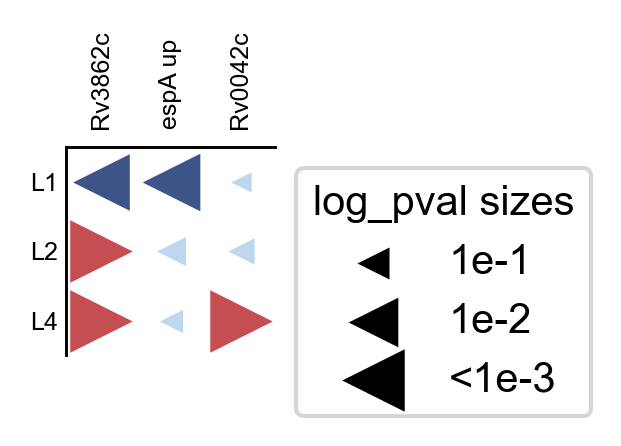

In [71]:
output_dir = 'outputs/figures'
output_name = '7A_modernity.pdf'

plot_df = pd.read_csv(
    'outputs/tables/TableS7_modernity.csv', index_col=[0, 1])

def linearScale(value, val_min=0.3, val_max=3, new_min=1, new_max=225):
    if value <= val_min:
        return new_min
    if value >= val_max:
        return new_max
    return ((
        (value - val_min) / (val_max - val_min)) * (new_max - new_min) + new_min)

xlabels = ['Rv3862c', 'espA up', 'Rv0042c']
ylabels = ['L1', 'L2', 'L4']
y_values = []
x_values = []
sizes = []
markers = []
colors_list = []
for x, site in enumerate(xlabels):
    for y, lineage in enumerate(ylabels):
        x_values.append(x)
        y_values.append(y)
        pval_greater = plot_df.loc[(site, lineage), 'pval_greater']
        pval_less = plot_df.loc[(site, lineage), 'pval_less']
        if pval_greater < pval_less:
            markers.append('>')
            if pval_greater < 0.05:
                colors_list.append(colors['dred'])
            else:
                colors_list.append(colors['lred'])
        if pval_less < pval_greater:
            markers.append('<')
            if pval_less < 0.05:
                colors_list.append(colors['dblue'])
            else:
                colors_list.append(colors['lblue'])
        sizes.append(linearScale(-np.log10(min(pval_greater, pval_less))))

fig, ax = plt.subplots(1, 1, figsize=(0.9, 0.9))
for i in range(len(x_values)):
    ax.scatter(
        x_values[i:i+1], y_values[i:i+1], s=sizes[i:i+1], color=colors_list[i:i+1], marker=markers[i], lw=0,)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-0.5, 2.5)
ax.invert_yaxis()
ax.set_xticks(range(0,3))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticks(range(0,3))
ax.set_yticklabels(ylabels)

# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
size_legend = [
    plt.scatter([-1], [-1], marker='<', lw=0, color='k', s=linearScale(s))
    for s in -np.log10([0.1, 0.01, 0.001])]
labels_size = ['1e-1', '1e-2', '<1e-3']
legend = ax.legend(
    size_legend, labels_size,
    title='log_pval sizes', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(bottom=True, top=False)
ax.tick_params(axis='y', length=0)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## Drug

In [74]:
alpha = 0.05

drug_overlap_df = pd.read_csv(
        'outputs/tables/TableS7_abx_associations.csv',
        index_col=[0, 1, 2])
# trim down to data of interest
drug_overlap_df = drug_overlap_df.loc[
    pd.IndexSlice[
        ['Rv3862c', 'espACD', 'Rv0042c'],
        ['isoniazid', 'rifampicin', 'streptomycin', 'ethambutol', 'pyrazinamide'],
        ['L1', 'L2', 'L4']]]

drug_overlap_df.loc[:, 'fdr_pass'] = multipletests(
    drug_overlap_df.est_pvalue, method='fdr_bh', alpha=0.05)[0]

drug_overlap_df.loc[:, 'pval_pass'] = drug_overlap_df.est_pvalue < alpha

In [75]:
# prepare for plotting
pvals = -np.log10(drug_overlap_df.loc[:, 'est_pvalue'].unstack(level=1).T.loc[
    ['isoniazid', 'rifampicin', 'streptomycin', 'ethambutol', 'pyrazinamide'],
    pd.IndexSlice[['Rv3862c', 'espACD', 'Rv0042c'], ['L1', 'L2', 'L4']]])
passfdr = drug_overlap_df.loc[:, 'fdr_pass'].unstack(level=1).T.loc[
    ['isoniazid', 'rifampicin', 'streptomycin', 'ethambutol', 'pyrazinamide'],
    pd.IndexSlice[['Rv3862c', 'espACD', 'Rv0042c'], ['L1', 'L2', 'L4']]]
passpval = drug_overlap_df.loc[:, 'pval_pass'].unstack(level=1).T.loc[
    ['isoniazid', 'rifampicin', 'streptomycin', 'ethambutol', 'pyrazinamide'],
    pd.IndexSlice[['Rv3862c', 'espACD', 'Rv0042c'], ['L1', 'L2', 'L4']]]

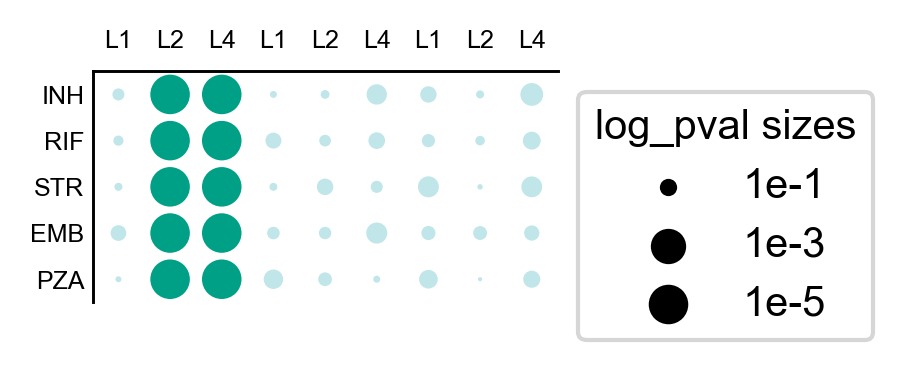

In [78]:
output_dir = 'outputs/figures'
output_name = '7B_drug_resistance.pdf'


new_max = 90
new_min = 1
rescale = lambda x: (new_max - new_min) * (x - np.min(pvals)) / (np.max(pvals) - np.min(pvals)) + new_min
pvals_rescaled = rescale(pvals)
    

y_values = []
x_values = []
sizes = []
colors_list = []
for y, x in product(range(pvals.shape[0]), range(pvals.shape[1])):
    x_values.append(x)
    y_values.append(y)
    sizes.append(pvals_rescaled.iloc[y, x])
    if passfdr.iloc[y, x]:
        colors_list.append(colors['dgreen'])
    else:
        colors_list.append(colors['lgreen'])


fig, ax = plt.subplots(1, 1, figsize=(2, 1))

ax.scatter(
    x_values, y_values, s=sizes, color=colors_list, marker='o', lw=0,)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()

# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
size_legend = [
    plt.scatter([-1], [-1], marker='o', lw=0, color='k', s=s)
    for s in rescale(-np.log10([0.1, 0.0001, 0.00001]))]
labels_size = ['1e-1', '1e-3', '1e-5']
legend2 = ax.legend(
    size_legend, labels_size,
    title='log_pval sizes', loc='upper left', bbox_to_anchor=(1, 1))

ax.set_ylim(4.5, -0.5)
ax.set_xlim(-.5, 8.5)

ax.set_xticks(range(0,9))
ax.set_xticklabels([
    'L1', 'L2', 'L4',
    'L1', 'L2', 'L4',
    'L1', 'L2', 'L4',])
ax.set_yticks(range(0,5))
ax.set_yticklabels([
    'INH', 'RIF', 'STR', 'EMB', 'PZA'])
ax.tick_params(axis='y', length=0)
sns.despine(bottom=True, top=False)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## Transmission

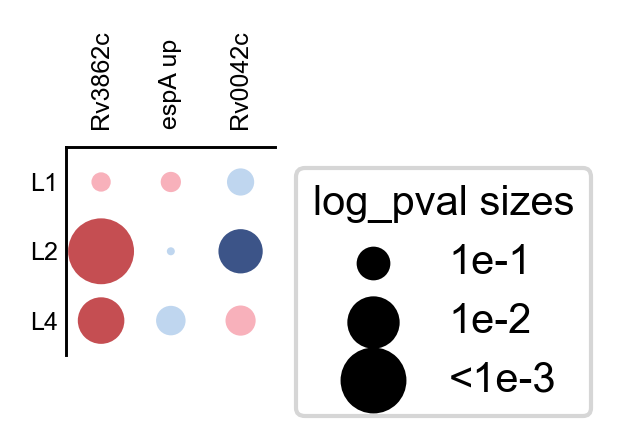

In [92]:
output_dir = 'outputs/figures'
output_name = '7C_full_tree_transmission.pdf'

plot_df = pd.read_csv(
    'outputs/tables/TableS7_transmission.csv', index_col=['site', 'lineage'])
plot_df = plot_df.loc[plot_df.loc[:, 'tree'] == 'all', :]

def linearScale(value, val_min=0.3, val_max=3, new_min=1, new_max=250):
    if value <= val_min:
        return new_min
    if value >= val_max:
        return new_max
    return ((
        (value - val_min) / (val_max - val_min)) * (new_max - new_min) + new_min)

xlabels = ['Rv3862c', 'espA up', 'Rv0042c']
ylabels = ['L1', 'L2', 'L4']
y_values = []
x_values = []
sizes = []
colors_list = []
for x, site in enumerate(xlabels):
    for y, lineage in enumerate(ylabels):
        x_values.append(x)
        y_values.append(y)
        pval_greater = plot_df.loc[(site, lineage), 'pval_greater']
        pval_less = plot_df.loc[(site, lineage), 'pval_less']
        if pval_greater < pval_less:
            if pval_greater < 0.05:
                colors_list.append(colors['dblue'])
            else:
                colors_list.append(colors['lblue'])
        if pval_less < pval_greater:
            if pval_less < 0.05:
                colors_list.append(colors['dred'])
            else:
                colors_list.append(colors['lred'])
        sizes.append(linearScale(-np.log10(min(pval_greater, pval_less))))

fig, ax = plt.subplots(1, 1, figsize=(0.9, 0.9))
ax.scatter(
    x_values, y_values, s=sizes, color=colors_list, marker='o', lw=0,)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-0.5, 2.5)
ax.invert_yaxis()
ax.set_xticks(range(0,3))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticks(range(0,3))
ax.set_yticklabels(ylabels)

# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
size_legend = [
    plt.scatter([-1], [-1], marker='o', lw=0, color='k', s=linearScale(s))
    for s in -np.log10([0.1, 0.01, 0.001])]
labels_size = ['1e-1', '1e-2', '<1e-3']
legend = ax.legend(
    size_legend, labels_size,
    title='log_pval sizes', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(bottom=True, top=False)
ax.tick_params(axis='y', length=0)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

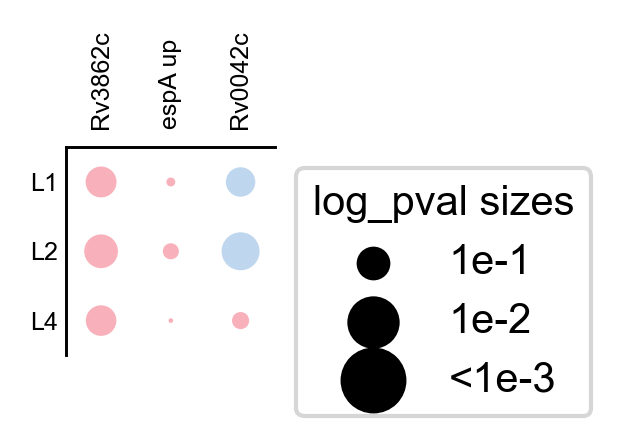

In [93]:
output_dir = 'outputs/figures'
output_name = '7C_sensitive_tree_transmission.pdf'

plot_df = pd.read_csv(
    'outputs/tables/TableS7_transmission.csv', index_col=['site', 'lineage'])
plot_df = plot_df.loc[plot_df.loc[:, 'tree'] == 'sensitive', :]

def linearScale(value, val_min=0.3, val_max=3, new_min=1, new_max=250):
    if value <= val_min:
        return new_min
    if value >= val_max:
        return new_max
    return ((
        (value - val_min) / (val_max - val_min)) * (new_max - new_min) + new_min)

xlabels = ['Rv3862c', 'espA up', 'Rv0042c']
ylabels = ['L1', 'L2', 'L4']
y_values = []
x_values = []
sizes = []
colors_list = []
for x, site in enumerate(xlabels):
    for y, lineage in enumerate(ylabels):
        x_values.append(x)
        y_values.append(y)
        pval_greater = plot_df.loc[(site, lineage), 'pval_greater']
        pval_less = plot_df.loc[(site, lineage), 'pval_less']
        if pval_greater < pval_less:
            if pval_greater < 0.05:
                colors_list.append(colors['dblue'])
            else:
                colors_list.append(colors['lblue'])
        if pval_less < pval_greater:
            if pval_less < 0.05:
                colors_list.append(colors['dred'])
            else:
                colors_list.append(colors['lred'])
        sizes.append(linearScale(-np.log10(min(pval_greater, pval_less))))

fig, ax = plt.subplots(1, 1, figsize=(0.9, 0.9))
ax.scatter(
    x_values, y_values, s=sizes, color=colors_list, marker='o', lw=0,)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-0.5, 2.5)
ax.invert_yaxis()
ax.set_xticks(range(0,3))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticks(range(0,3))
ax.set_yticklabels(ylabels)

# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
size_legend = [
    plt.scatter([-1], [-1], marker='o', lw=0, color='k', s=linearScale(s))
    for s in -np.log10([0.1, 0.01, 0.001])]
labels_size = ['1e-1', '1e-2', '<1e-3']
legend = ax.legend(
    size_legend, labels_size,
    title='log_pval sizes', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(bottom=True, top=False)
ax.tick_params(axis='y', length=0)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

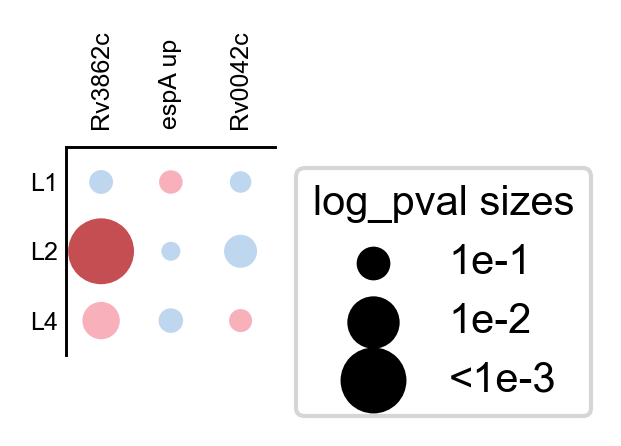

In [94]:
output_dir = 'outputs/figures'
output_name = '7C_resistant_transmission.pdf'

plot_df = pd.read_csv(
    'outputs/tables/TableS7_transmission.csv', index_col=['site', 'lineage'])
plot_df = plot_df.loc[plot_df.loc[:, 'tree'] == 'resistant', :]

def linearScale(value, val_min=0.3, val_max=3, new_min=1, new_max=250):
    if value <= val_min:
        return new_min
    if value >= val_max:
        return new_max
    return ((
        (value - val_min) / (val_max - val_min)) * (new_max - new_min) + new_min)

xlabels = ['Rv3862c', 'espA up', 'Rv0042c']
ylabels = ['L1', 'L2', 'L4']
y_values = []
x_values = []
sizes = []
colors_list = []
for x, site in enumerate(xlabels):
    for y, lineage in enumerate(ylabels):
        x_values.append(x)
        y_values.append(y)
        pval_greater = plot_df.loc[(site, lineage), 'pval_greater']
        pval_less = plot_df.loc[(site, lineage), 'pval_less']
        if pval_greater < pval_less:
            if pval_greater < 0.05:
                colors_list.append(colors['dblue'])
            else:
                colors_list.append(colors['lblue'])
        if pval_less < pval_greater:
            if pval_less < 0.05:
                colors_list.append(colors['dred'])
            else:
                colors_list.append(colors['lred'])
        sizes.append(linearScale(-np.log10(min(pval_greater, pval_less))))

fig, ax = plt.subplots(1, 1, figsize=(0.9, 0.9))
ax.scatter(
    x_values, y_values, s=sizes, color=colors_list, marker='o', lw=0,)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-0.5, 2.5)
ax.invert_yaxis()
ax.set_xticks(range(0,3))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticks(range(0,3))
ax.set_yticklabels(ylabels)

# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
size_legend = [
    plt.scatter([-1], [-1], marker='o', lw=0, color='k', s=linearScale(s))
    for s in -np.log10([0.1, 0.01, 0.001])]
labels_size = ['1e-1', '1e-2', '<1e-3']
legend = ax.legend(
    size_legend, labels_size,
    title='log_pval sizes', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(bottom=True, top=False)
ax.tick_params(axis='y', length=0)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)